# Lecture 17 - Artificial Neural Networks with PyTorch

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_17-ANNs_with_PyTorch/Lecture_17-ANNs_with_PyTorch.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_17-ANNs_with_PyTorch/Lecture_17-ANNs_with_PyTorch.ipynb)

<a id='top'></a>

- [17.1 Introduction to PyTorch](#17.1-introduction-to-pytorch)
- [17.2 Loading the Dataset](#17.2-loading-the-dataset)
- [17.3 Training Neural Networks: Revisited](#17.3-training-neural-networks:-revisited)
- [17.4 Creating, Training, and Evaluating the Model](#17.4-creating,-training,-and-evaluating-the-model)
- [17.5 Using a Custom Dataset and a Pretrained Model](#17.5-using-a-custom-dataset-and-a-pretrained-model)
- [17.6 Model Saving and Loading in PyTorch](#17.6-model-saving-and-loading-in-pytorch)
- [References](#references)

## 17.1 Introduction to PyTorch <a name='17.1-introduction-to-pytorch'></a>

**PyTorch** is currently one of the most popular deep learning frameworks. It is an open-source library built upon the Torch library, and it was developed by Meta AI (previously Facebook AI). It is now part of the Linux Foundation.

As we learned in Tutorial 8, PyTorch provides tensor operations that can conveniently be performed using CPU or GPU devices. It also provides automatic differentiation operations (auotgrad) with Neural Networks.

In this lecture we will explain how to train Neural Networks with PyTorch. PyTorch has similar functionality to Keras and TensorFlow, as it allows to import neural network layers, offers loss functions and optimizers, etc. It has a slightly lower-level of abstraction in comparison to Keras. On the other hand, there are high-level libraries for PyTorch, such as [PyTorch Lightning](https://www.pytorchlightning.ai/) and [fast.ai](https://www.fast.ai/).

Let's import the required libraries. In the next cell, we imported `torch`, several utility functions, and modules such as `torch.nn` that provides functions and tools for building and training neural networks, and `torchvision` that provides functions and tools for image processing and related computer vision tasks.

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
# trochvision is part of PyTorch consisting of models and datasets for computer vision
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

## 17.2 Loading the Dataset <a name='17.2-loading-the-dataset'></a>

We will use one of the most common deep learning datasets - MNIST (Modified National Institute of Standards and Technology database). MNIST is a dataset of handwritten digits from 0 to 9, containing 60,000 training images and 10,000 testing images. Each image has 28x28 pixels size.

PyTorch provides access to several datasets, and MNIST can be loaded conveniently by using the `datasets.MNIST` function. In the used arguments, `root` is the directory where the dataset exists, and `transform` can be used to apply data scaling, image resizing, or other transformation operations. Such operations are not required for this dataset.

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.84MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


In [ ]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


The images in MNIST are gray images, and therefore, they have only one channel. To check the shape of the images we can use `size()` in PyTorch which corresponds to `shape` in NumPy.

In [ ]:
print(training_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


Let's visualize several randomly selected images from the training dataset, and show their class labels.

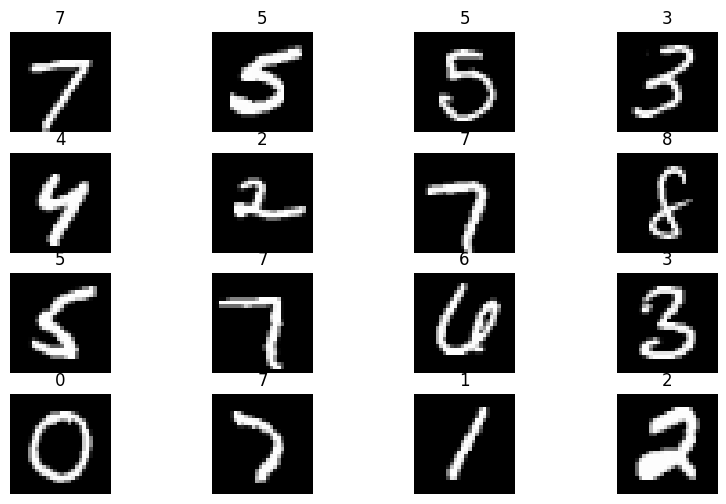

In [ ]:
figure = plt.figure(figsize=(10, 6))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### DataLoader

In PyTorch, `DataLoader` is an iterable object used for passing a batch of input data at each iteration during the model training. `DataLoader` takes as arguments the dataset that we are going to use, `shuffle` indicates if the data should be shuffled, and `batch_size` is self-explanatory. While we always need to shuffle the data in the training dataset to avoid correlated data (e.g., the training dataset can have first all 0 images, then 1 images, etc.), we don't need to shuffle the test or validation datasets because they are not used for training.

In [ ]:
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=128)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=128)

The output of DataLoader is a batch of input images and the corresponding target labels. To inspect a batch of data we need to use the `iter` method to obtain an iterator, and afterward we can use the `next()` function to iterate over the batches. Note that `DataLoader` converted the images into a format (1, 28, 28) where 1 is the number of channels of the images.

Note also that in PyTorch the default convention for representing the dimensions of images in tensors is the "channels first" format as in (1, 28, 28), as opposed to Keras-TensorFlow where the default convention is the "channels last" format as in (28, 28, 1).

In [ ]:
# check is train_dataloader is an iterator
iter(train_dataloader) is train_dataloader

False

In [ ]:
# Inspect a batch of images and labels
batch_images, batch_labels = next(iter(train_dataloader))
print("Batch images shape:", batch_images.size())
print("Batch labels shape:", batch_labels.size())

Batch images shape: torch.Size([128, 1, 28, 28])
Batch labels shape: torch.Size([128])


## 17.3 Training Neural Networks: Revisited <a name='17.3-training-neural-networks:-revisited'></a>

Before explaining how to create and train NNs with PyTorch, let's briefly review the section of training NN from Lecture 15, as it will be helpful to understand the PyTorch code.

Training NNs is performed by iterative updates of the model parameters with the goal to minimize the difference between the model predictions and target labels.

Each iteration in the training phase includes the following 4 steps:

1. Forward pass (forward propagation)
2. Loss calculation
3. Error backpropagation (backward pass)
4. Model parameters update

**Forward propagation** or **forward pass**, involves passing the input data through all hidden layers of the neural network toward the output layer to obtain the network predictions. If the input data is an image, the image is transformed through the layers of the network, and for classification problems, the output is a vector of predicted class probabilities.

**Loss calculation** is the second step, in which the loss of the network is calculated as a difference between the network predictions and the target labels. For classification tasks, standard loss function is crossentropy loss, and for regression tasks loss functions include mean-squared deviation and mean absolution deviation.

**Error backpropagation**, also called **backward pass** or **backward propagation** involves propagating the predicted outputs back through the network, from the last layer backward toward the first layer. During the backward step, the gradients of the loss with respect to the model parameters $\nabla\mathcal{L}(𝜃)$ are calculated. The gradients quantify the impact of changing the parameters in the network to the predicted outputs. Automatic calculation of the gradients (automatic differentiation) is available in all current deep learning libraries, which significantly simplifies the implementation of deep learning algorithms.

**Model parameters update** is the last step in which new values for the model parameters are calculated and updated, typically using the **Gradient Descent** algorithm.



<img src="images/forward_backward.png" width="800">

*Figure: Steps in training neural networks.*

And to briefly review the **Gradient Descent** algorithm, it uses the gradient of the loss function to estimate the slope of the loss function. By updating the parameters in the opposite direction of the gradient of the loss $\nabla\mathcal{L}$, the algorithm finds parameters $𝜃$ for which the loss $\mathcal{L}$ has a minimal value.

<img src="images/gradient_descent.png" width="1000">

*Figure: Gradient descent algorithm.*

Almost all modern neural networks are trained by applying a modified version of the Gradient Descent algorithm. Examples of such advanced Gradient Descent algorithms include Adam, SGD (Stochastic Gradient Descent), RMSprop, Adagrad, Nadam, and others.

To train a neural network, the steps of forward pass, loss calculation, backward pass, and parameter update are performed iteratively for each batch of the input data.  Each iteration through the input data constitutes one epoch. This is shown in the following simple pseudocode.

```
for epoch in number_of_epochs:
    for batch in number_of_batches:
        forward pass
        calculate loss
        backward pass (calculate the gradients)
        update parameters
 ```

For predicting on test data (*inference*) only a forward pass through the model is needed, and it does not require to calculate the loss, perform the backward pass, or update the model parameters.

## 17.4 Creating, Training, and Evaluating the Model <a name='17.4-creating,-training,-and-evaluating-the-model'></a>

### Model Definition

We will define a Convolution Neural Network using the `nn.Module` in PyTorch, which is a superclass for creating neural networks in PyTorch. I.e., the CNN model will represent a subclass of the superclass `nn.Module`. Inheriting from the `nn.Module` allows to use various PyTorch functionalities for our model. Let's use the name `CNN` for the subclass that we will use to instantiate our model.

In the `__init__()` constructor method of the CNN class, we will list the layers of the network as attributes of the class. For this task, let's use 2 convolutional layers that we will name `conv1` and `conv2`, a max-pooling layer `maxpool`, ReLU layer `relu`, and a dense layer named `dense`. The `nn.Module` also offers several other attributes and methods which we will inherit via `super().__init__()` (or we can also use `nn.Module.__init__(self)` to achieve the same result, as you may recall from the lecture on OOP).

**Conv2d layers** in PyTorch have similar arguments to the Keras library, as follows:

- *in_channels* (int), number of input channels to the layer, which for the first layer in the network is the number of channels in input images, and for all other layers is the number of output channels from the preceding layer  (recall that the `in_channels` argument is not provided in the Keras layers and it is determined automatically, however in PyTorch we need to specify it).
- *out_channels* (int), number of channels that are produced by the layer (i.e., the number of used convolutional filters).
- *kernel_size* (int or tuple), size of the convolving kernel (it is typically 3, and sometimes can also be 5, 7, etc.).
- *padding* (int or tuple, optional), padding can be added to both sides of the input images; default value is 0, i.e., no padding.

Regarding the image padding, note that applying a convolutional filter to an image produces a convolved image with a reduced size. To obtain a resulting feature map of the same size as the original image, padding is applied. For instance, in the figure below, a filter with a kernel size 3x3 is applied to a padded image of size 7x7, and the output is a feature with size 5x5. In this case, the original image of size 5x5 is padded with zeros on all four sides, and the size was changed to 7x7. In PyTorch `padding=1` means that one row or column is added on all sides of the image. This is equivalent to `padding='same'` in Keras.

<img src="images/padding.png" width="700">

*Figure: Image padding.*

**Max pooling layers** are defined the same as in Keras, and have as argument the kernel size for the pooling operation. Most networks use kernel size of 2 for the pooling operation.

The outputs of convolutional layers are passed through a **ReLU activation layer** which is short for **Re**ctified **L**inear **U**nit activation function. As we explained, activation functions introduce non-linearity to the layers in the model, which allows to learn complex relations between the inputs and outputs. Most modern neural networks apply ReLU activation function, or some variants of it. ReLU activation function is shown in the next figure, and it outputs 0 if the input is negative, or outputs the input if it is positive.

<img src="images/relu.png" width="400">

*Figure: ReLU activation function.*

**Fully-connected (dense) layers** in PyTorch are defined with the `nn.Linear` layer, and they have as arguments:

- *in_features* (int), number of input features to the layer (this argument is not provided in the Keras Dense layer, it is determined automatically).
- *out_features* (int), number of output features of the layer.

After we define the layers in the model, we will add the method `forward` to define the forward pass for the model. For this model, we will use 2 blocks of convolutional, ReLU, and max-pooling layers, and a final dense layer to make the predictions. Also recall that in the previous lecture we used the Flatten layer to convert the outputs from the convolutional layers into one-dimensional vectors. Here, we use `torch.flatten()` to flatten the tensors.

The Convolutional Neural Network in PyTorch defined below is equivalent to the following Convolutional Neural Network in Keras-TensorFlow.

    # Define the layers in the model
    inputs = Input(shape=(28, 28, 1))
    conv1 = Conv2D(filters=16, kernel_size=3, padding='same')(inputs)
    pool1 = MaxPooling2D()(conv1)
    conv2 = Conv2D(filters=32, kernel_size=3, padding='same')(pool1)
    pool2 = MaxPooling2D()(conv2)
    flat = Flatten()(pool2)
    outputs = Dense(10, activation='softmax')(flat)

    # Define the model with inputs and outputs
    cifar_cnn = Model(inputs, outputs)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # maxpooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # ReLU activation layer
        self.relu = nn.ReLU()

        # fully connected layer, output 10 classes
        self.dense = nn.Linear(in_features=32 * 7 * 7, out_features=10)

    def forward(self, x):
        # sequence of layers
        # first block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # second block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # flatten the output of the second block to 1D vector
        x = torch.flatten(x, 1)

        # output layer
        output = self.dense(x)

        return output

Next, we will create an instance of the model, here named `cnn_model`.

In [ ]:
model = CNN()

In PyTorch we need to specify the device on which the model will be trained, i.e., whether we will use CPU, GPU, or TPU. We can do that with `torch.device`, as in the next cell.

I am using Google Colab with GPU available, therefore in the output of the cell the device type is `'cuda'`.

CUDA (Compute Unified Device Architecture) is a library that allows using GPU computing for machine learning tasks, which parallelizes the computations, and speeds up the model training.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Using `to(device)` will transfer the ConvNet model to the device, which in our case is GPU. And later, we will also move the data for training the model to the GPU.

In [ ]:
model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dense): Linear(in_features=1568, out_features=10, bias=True)
)

### Model Training

Before training the model, we need to define a loss function and an optimizer. As we mentioned in the previous lecture, crossentropy loss is commonly used with classification problems, and Adam is a standardly used optimization algorithm.

In [ ]:
# define loss function (cross-entropy)
criterion = nn.CrossEntropyLoss()
# define an optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

The above loss is equivalent to the  `sparse_categorical_crossentropy` in Keras-TensorFlow. Therefore, if the target variable is in one-hot encoding format, we will need to first convert into 1D tensor containing the integer class labels. Similarly, if we would like to perform binary classification in PyTorch we can specify a binary crossentropy loss with `nn.BCELoss`.

The following cell trains the model, and it is similar to the `fit` function in scikit-learn or Keras. It contains a for-loop over the epochs, and afterwards the variables `running_loss`, `total`, and `sum_correct` are initialized and will be used to store the values of the training loss and accuracy at each epoch.

Next, a batch of images is loaded, and moved to the device (GPU in this case). And, the above four steps are performed: forward pass, loss calculation, backward pass, and parameters update.

The remaining lines calculate the loss and accuracy and display their values after each epoch.

The `item()` method is used to convert the tensors to NumPy floats and bring them to the CPU. PyTorch uses GPU for performing calculations, and CPU for displaying and plotting the variables.

Please read the comments in the next cell to better understand the code.

In [ ]:
# total number of training epochs
epoch_num = 10

# loop over the number of epochs
for epoch in range(epoch_num):

    # the loss values for each epoch
    running_loss = 0.0
    # total images in each epoch
    total = 0
    # correctly predicted images in each epoch
    sum_correct = 0

    ### training
    # indicate this is a training step
    model.train()

    # loop over the batches in the training dataset
    for i, data in enumerate(train_dataloader):
        # get a batch of inputs and labels
        inputs, labels = data
        # send the inputs and labels to the device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # set the gradient to zero, to clear the values from the last iteration
        optimizer.zero_grad()

        # forward pass: propagate the inputs through the network to obtain output predictions
        outputs = model(inputs)
        # calculate the loss (crossentropy)
        loss = criterion(outputs, labels)
        # backward pass: propagate backward and calculate the gradients
        loss.backward()
        # update the model parameters (using the optimizer Adam)
        optimizer.step()

        # calculate the loss and accuracy for the current batch
        # 'loss' is average loss per sample of the current batch
        #  this loss is added to the 'running_loss' which accumulates the loss over all batches
        # '.item()' converts the value of the PyTorch tensor into Python float32 and moves its value to the CPU
        # 'inputs.size(0)' is the batch size (number of samples in the current batch)
        running_loss += loss.item() * inputs.size(0)
        # 'predicted' is the vector of class labels for images in the current batch
        # this is similar to np.argmax
        _, predicted = torch.max(outputs.data, dim=1)
        # 'sum_correct' is the number of correctly predicted images in each epoch
        # the added value on the right side is the number of correctly predicted images in the current batch
        sum_correct += (predicted==labels).sum().item()
        # 'total' is the number of images (or labels) in each epoch
        # the added value on the right side is the number of images (or labels) in the current batch
        total += labels.size(0)

    # # loss for each epoch
    epoch_loss = running_loss / total
    # accuracy for each epoch
    epoch_accuracy = sum_correct / total

    # print the epoch number, training loss, and training accuracy
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {epoch_loss:.4f}\t',
              f'\t Training accuracy: {100*epoch_accuracy:2.3f}')

Epoch: 1/10	 Training loss: 0.1592	 	 Training accuracy: 95.112
Epoch: 2/10	 Training loss: 0.0545	 	 Training accuracy: 98.330
Epoch: 3/10	 Training loss: 0.0450	 	 Training accuracy: 98.583
Epoch: 4/10	 Training loss: 0.0392	 	 Training accuracy: 98.765
Epoch: 5/10	 Training loss: 0.0338	 	 Training accuracy: 98.973
Epoch: 6/10	 Training loss: 0.0317	 	 Training accuracy: 98.997
Epoch: 7/10	 Training loss: 0.0283	 	 Training accuracy: 99.092
Epoch: 8/10	 Training loss: 0.0274	 	 Training accuracy: 99.128
Epoch: 9/10	 Training loss: 0.0259	 	 Training accuracy: 99.117
Epoch: 10/10	 Training loss: 0.0253	 	 Training accuracy: 99.220


### Model Evaluation

The following cell evaluates the accuracy on the test dataset. For this step, we will use `with torch.no_grad()` context manager, to indicate that there is no need to calculate the gradients, since the model parameters are not updated during model evaluation. As we know, only the forward pass is required for evaluation on test images.

In [ ]:
### testing

# these variables are similar to the variables for the training phase
test_running_loss = 0.0
test_total = 0
test_correct = 0

# torch.no_grad() specify not to update the model during testing
with torch.no_grad():
  # loop over the batches in the test dataset
  for i, data in enumerate(test_dataloader):
      # get a batch of inputs and labels
      inputs, labels = data
      # send the inputs and labels to the GPU
      inputs, labels = inputs.to(device), labels.to(device)

      # forward pass
      outputs = model(inputs)
      # calculate the loss
      loss = criterion(outputs, labels)
      # there is no backward pass in the testing step

      # these variables are the same as in the training step
      test_running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100*test_correct/test_total:2.3f}')

Accuracy of the model on the test images: 98.550


## 17.5 Using a Custom Dataset and a Pretrained Model <a name='17.5-using-a-custom-dataset-and-a-pretrained-model'></a>

### Loading the Dataset

In this section, we will study one more classification task with CNNs in PyTorch. We will use the image dataset `Imagenette`, which is just a small subset of images from the large dataset ImageNet. There are a few versions of the `Imagenette` dataset, and we will use a version that has 9,469 images, categorized into 10 classes. The classes are: tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, and parachute.

We will explore two different cases for the organization of a custom dataset to be loaded:

- Case 1, the dataset consists of separate directories for each class, where each subdirectory contains the data samples for one class
- Case 2, the dataset has one directory with all data samples and a spreadsheet (or text file) that contains the labels for all samples

### Case 1: One Directory for Each Class

As we stated, in this case, the dataset is organized into multiple directories, and each directory contains the data samples for one class.

Let's first mount the Google Drive since the dataset is saved on the drive, and uncompress the file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Uncompress the dataset
!unzip -uq "drive/MyDrive/Data_Science_Course/Fall_2025/Lectures/Lecture_17-NNs_with_PyTorch/data/imagenette_folders.zip" -d "sample_data/"

To see the dataset, click on the icon that looks like a folder located in the left-side panel in Google Colab, and under `sample_data` you will see the `imagenette_folders` directory. If we click on the arrow to expand it, we can see that it has two main subdirectories `train` and `val`, each of which has 10 subdirectories that contain the images for each class in the dataset.

in PyTorch, loading datasets that have such organization is very simple. The function `ImageFolder` is designed for such datasets, and it automatically labels and organizes the data. In the cell below, we just provide the path to the dataset, and `transform` for resizing the images to 128x128 pixel size and converting the data to PyTorch tensors.  

After that, we use the `DataLoader` to create train and validation dataloader objects for iterating over the datasets.


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_dataset = ImageFolder(root='sample_data/imagenette_folders/train/', transform=transform)
val_dataset = ImageFolder(root='sample_data/imagenette_folders/val', transform=transform)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

### Case 2: All Data Points in a Single Directory

In this case, all images are saved into one single directory. Let's uncompress the file. Again, if we click on the folder icon in the left-side panel in Google Colab, we can notice that the dataset has one directory `images` that contains all images, and a file `labels.csv` that has the labels for all images.

In [ ]:
# Uncompress the dataset
!unzip -uq "drive/MyDrive/Data_Science_Course/Fall_2025/Lectures/Lecture_17-NNs_with_PyTorch/data/imagenette_all.zip" -d "sample_data/"

Custom datasets in PyTorch are created as a subclass of the `Dataset` class, which is imported from `torch.utils.data`. The custom datasets should inherit from `Dataset` and they are required to override the following two methods:

- `__len__()`, to return the number of instances in the dataset.
- `__getitem__()` to support indexing and return the instances with the specified index `idx` in the dataset.

In the cell below, we used `MyDataset` as the name of the subclass. In the `__init__()` method we defined the root directory where the dataset is located, the subdirectory `image_folder` where the images are saved, we read the `labels.csv` file as a Pandas DataFrame, and we defined `transform` that will apply transformation to the images.

The `__len__()` method returns the length of the dataset, which is the same as the number of rows in `labels.csv`.

In the `__get_item__()` method, `idx` is the index of the data point to load, `img_name` is the file path to the image with index idx (where the image files are named 'img_0001.jpg', 'img_0002.jpg', etc.), `image` is the image file and it is loaded with the `Image.open()` method in PIL (Python Imaging Library), and afterward transformations are applied to the image. The `label` for each image is extracted from the Pandas DataFrame `labels_file`. Finally, the `__getitem__()` method returns a tuple containing the transformed image and its corresponding label.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'images')
        self.labels_file = pd.read_csv(os.path.join(root_dir, 'labels.csv'), header=None)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file.iloc[idx, 0]

        return image, label

Now, let's use the class `MyDataset` to instantiate the dataset. There are 9,469 images in total in the dataset.

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

dataset = MyDataset(root_dir='sample_data/imagenette_all', transform=transform)

In [ ]:
print(len(dataset))

9469


To create training, testing, and validation subsets, we will first use scikit-learn's `train_test_split` to split the indices into three groups.

Afterward, we will use the `Subset` class in PyTorch to partition the dataset into training, testing, and validation datasets based on the indices.

And, as in the above examples, we will use `DataLoader` to enable iterating over batches of images and labels.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test subsets
train_indices_1, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=123)

# Split the dataset into train and validation subsets
train_indices, val_indices = train_test_split(train_indices_1, test_size=0.2, random_state=123)

In [ ]:
# Create training, testing, and validation subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

In [ ]:
# Create training, testing, and validation dataloaders for iterating over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

6060
1894
1515


PyTorch has a function `make_grid()` which allows to plot a grid of images.

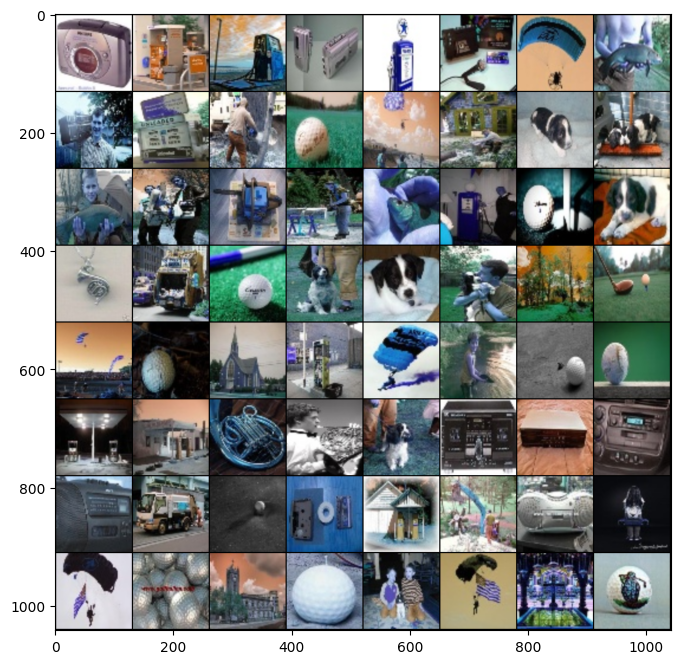

In [ ]:
# show several images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images and labels
images, labels = next(iter(train_dataloader))

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

### Model Loading

PyTorch has pretrained models that are easy to be loaded and used. Let's import a VGG model pretrained on the ImageNet dataset.

In [ ]:
from torchvision.models import vgg16

#VGG16
vgg_model = vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:11<00:00, 49.5MB/s]


To use the VGG model with our dataset, we will change the last layer in the model with a dense layer that will output 10 features, since there are 10 classes in the dataset. Notice in the following cell which shows the architecture of the VGG model that the last layer is layer '6' in the classifier (where the classifier refers to the Linear (dense), ReLU, and Droput layers that follow the convolutional and maxpooling layers). In the original VGG model that was trained on ImageNet, the last layer has 1,000 output neurons, since there are 1,000 classes in ImageNet.

In [ ]:
# replace the last layer in VGG with a dense layer to predict 10 classes
vgg_model.classifier._modules['6'] = nn.Linear(4096, 10)

In [ ]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Modular Code: Training and Validation for One Epoch

For this example, let's write functions for training and validating the model which we will call `train` and `validate`. These functions will group all required code for training and validation, and we can re-use such modular code in other scripts.

The functions are almost identical to the code that we used above. They return the accuracy and loss for the epoch. Note that we used the lines `model.train()` and `model.eval()` in these functions, which act as a switch for some specific layers that behave differently during training and evaluation. For example, Dropout and Batch Normalization layers are turned on during training and turned off during evaluation, which is controlled by these two lines.

In [ ]:
# train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train()

    for i, data in enumerate(train_loader):
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        sum_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # return the accuracy and loss
    return sum_correct/total, running_loss/total


# evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss/total

### Define Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)

### Model Training

The next cell contains code for training the model. Now we can call the `train` and `validate` functions to perform the training and validation steps for each epoch. The outputs are the average accuracy and loss, calculated at the end of each epoch. We will append those values to lists, which we will use later to plot the learning curves.

In [ ]:
# total number of training epochs
epoch_num = 10

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(vgg_model, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(vgg_model, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.4f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

Epoch: 1/10	 Training loss: 0.6580	 Training accuracy: 78.284	 Validation accuracy: 88.449
Epoch: 2/10	 Training loss: 0.2228	 Training accuracy: 92.739	 Validation accuracy: 88.911
Epoch: 3/10	 Training loss: 0.1048	 Training accuracy: 96.914	 Validation accuracy: 89.043
Epoch: 4/10	 Training loss: 0.0813	 Training accuracy: 97.244	 Validation accuracy: 89.043
Epoch: 5/10	 Training loss: 0.0640	 Training accuracy: 98.036	 Validation accuracy: 89.901
Epoch: 6/10	 Training loss: 0.0592	 Training accuracy: 98.036	 Validation accuracy: 90.495
Epoch: 7/10	 Training loss: 0.0267	 Training accuracy: 99.076	 Validation accuracy: 87.459
Epoch: 8/10	 Training loss: 0.0339	 Training accuracy: 98.944	 Validation accuracy: 90.495
Epoch: 9/10	 Training loss: 0.0645	 Training accuracy: 98.036	 Validation accuracy: 88.845
Epoch: 10/10	 Training loss: 0.0321	 Training accuracy: 98.927	 Validation accuracy: 90.363


The training and validation accuracies and loss are shown in the next figure. Note that Mathplotlib doesn't support plotting tensors that are on the GPU, and therefore, we needed to bring the values of the accuracies and losses to the CPU for plotting (e.g., by using `item()` as in the above code).

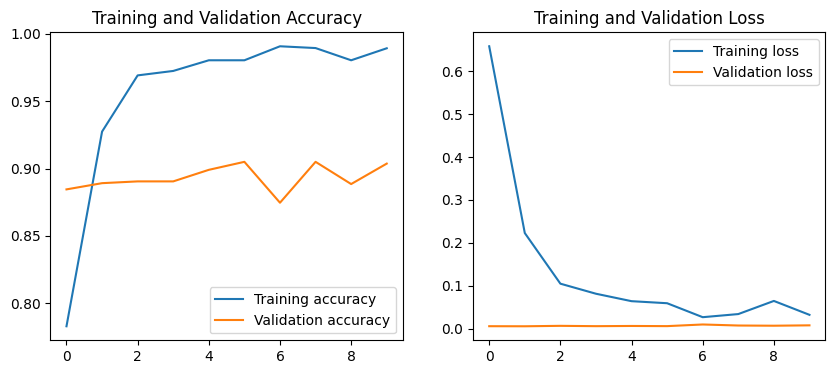

In [ ]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

### Model Evaluation

We can use the same function `validate` to evaluate the model performance on the test dataset.

In [ ]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(vgg_model, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 89.968


## 17.6 Model Saving and Loading in PyTorch <a name='17.6-model-saving-and-loading-in-pytorch'></a>

### Save and Load State Dictionary

To save PyTorch models we use `torch.save()` as shown below. The parameters of the model are stored in a state dictionary with `state_dict()`, and as expected, the path to the directory to save the model needs to be provided. A `state_dict()` is a dictionary that has as keys the layers in the network, and the values in the dictionary are the corresponding parameters in each layer.

A PyTorch convention is to use the extension `.pth` or `.pt` with the file path.

In [ ]:
torch.save(vgg_model.state_dict(), 'vgg_model_weights.pth')

Let's print the keys in the `state_dict` for the vgg model. The model has 30 layers in the `features` part, and 6 layers in the `classifier` part (as shown in one of the above cells). E.g., `features.0.weight` is the key for the weights in layer 0 and `features.0.bias` is the key for the biases in layer 0 of the model, where biases is a vector of trainable constant values that are added to the weights in each layer.

In [ ]:
print("Keys in the state_dict keys: \n", vgg_model.state_dict().keys())

Keys in the state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


To load a saved model, we need to have an instance of the model, and therefore let's create an instance `model_1`. Then, we use the `load_state_dict()` method with `torch_load()`. Internally PyTorch uses pickle to serialize and deserialize the  `state_dict()` when saving and loading.

In [ ]:
model_1 = vgg_model

model_1.load_state_dict(torch.load('vgg_model_weights.pth'))

<All keys matched successfully>

In [ ]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(model_1, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 89.968


### Save and Load the Entire Model

Instead of saving only the model parameters with the `state_dict()`, it is also possible to save the entire model in PyTorch, including the class definition, the architecture with the layers, and other related information, as in the next cell.

In [ ]:
torch.save(vgg_model, 'vgg_model_2.pth')

However, saving the state dictionary is the preferred way, since it results in a reduced file size, and it allows to share models accross different versions of PyTorch, whereas saved objects with the entire model may not be compatible between PyTorch versions. In addition, loading a saved state dictionary provides more flexibility and it allows to replace the model achitecture and fine-tune the model with a different architecture.

### Save and Load a Checkpoint

If we would like to save the model checkpoint after an epoch, and later resume the training, we will need to also save information about the loss and gradients at that epoch, along with the state dictionary. In the next cell, the checkpoint saves the last epoch, the state dictionary `model.state_dict()`, and the optimizer information `optimizer.state_dict()`.

In [ ]:
checkpoint = {'epoch': epoch,
              'state_dict': vgg_model.state_dict(),
              'optimizer_state' : optimizer.state_dict()}

torch.save(checkpoint, 'vgg_checkpoint.pth')

When loading the checkpoint, we will load the `'state_dict'`, `'optimizer_state'`, and `'epoch'`.

In [ ]:
model_2 = vgg_model

checkpoint = torch.load('vgg_checkpoint.pth')
model_2.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
epoch = checkpoint['epoch']

In [ ]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(model_2, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 89.968


## References <a name='references'></a>

1. Training a Classifier in PyTorch, available at: [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

[BACK TO TOP](#top)